# Geometric and Topological analysis of MNIST

**Can we classify images without looking at the pixels?**

In this project, we move beyond standard pixel-based classification of the MNIST dataset to investigate the underlying shape and structure of the data.

We compare three distinct approaches:

**Raw Pixels**: The baseline approach using pixel intensities.

**Global Geometry (UMAP)**: Manifold learning to capture the global "shape" of the dataset.

**Local Topology (TDA)**: Using Persistent Homology to extract topological features (loops and connected components) from individual digits.

**Key Results**:

**Performance**: Topological features alone—ignoring pixel values entirely—can achieve >90% accuracy using a Random Forest classifier, proving that the topological features hold significant signal.

**Geometry vs. Topology**: We find that UMAP effectively 'unfolds' the data manifold, allowing even a simple linear model to classify digits with high accuracy. In contrast, TDA extracts fundamental structural features (loops and components) that prove resilient to deformation.

**Robustness**: While TDA is resilient to continuous deformations, we demonstrate it is vulnerable to "Salt & Pepper" noise, which fundamentally alters the local topology (creating fake loops) more than it affects raw pixel statistics.

In [1]:
# --- COLAB SETUP ---
'''If you are another environment you might need to install some dependencies of other libraries.'''

import os
from importlib.metadata import version, PackageNotFoundError

# Define the target versions
requirements = {
    "giotto-tda": "0.6.2",
    "numpy": "1.26.4",
    "scikit-learn": "1.7.2",
    "umap-learn": "0.5.7",
    "pandas": "2.3.3",
    "matplotlib": "3.10.7",
    "seaborn": "0.13.2"
}

def check_packages(reqs):
    """Returns True if installation is needed."""
    for pkg, ver in reqs.items():
        try:
            current_ver = version(pkg)
            if current_ver != ver:
                print(f"Version mismatch for {pkg}: Found {current_ver}, need {ver}")
                return True
        except PackageNotFoundError:
            print(f"Package not found: {pkg}")
            return True
    return False

# Check if we need to install
if check_packages(requirements):
    print("Starting installation...")

    # Install Packages in order
    os.system("pip install -q giotto-tda==0.6.2")
    os.system("pip install -q numpy==1.26.4")
    os.system("pip install -q pandas==2.3.3")
    os.system("pip install -q matplotlib==3.10.7")
    os.system("pip install -q --no-deps --force-reinstall scikit-learn==1.7.2")
    os.system("pip install -q umap-learn==0.5.7")
    os.system("pip install -q  seaborn==0.13.2")

    print("Installation complete.")
    print("IMPORTANT: Go to the menu 'Runtime' -> 'Restart Session' now to apply these changes.")
else:
    print("Dependencies are already at the correct versions. No action needed.")

Dependencies are already at the correct versions. No action needed.


In [2]:
# Standard Data Science Stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-Learn
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression

#UMAP
import umap

# Image Processing
from scipy.ndimage import map_coordinates, gaussian_filter

# Topological Data Analysis(Giotto-TDA)
from gtda.images import Binarizer, HeightFiltration
from gtda.homology import CubicalPersistence
from gtda.diagrams import BettiCurve, PersistenceEntropy



#utilities
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)

# We will use a subset of all samples for better performance
subset_size = 10000
subset_indices = np.random.RandomState(42).choice(len(X), subset_size, replace=False)
X = X[subset_indices]
y= y[subset_indices]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=13)



## Chapter 1: Establishing a Baseline (The Pixel View)

Before applying advanced geometric or topological techniques, we must establish a baseline performance using the raw data.

In this section, we treat the images as flattened vectors of 784 independent features (28×28 pixels), effectively ignoring the spatial relationships between them. We will test two standard models to gauge the difficulty of the classification task:

Logistic Regression: To test linear separability in the raw pixel space.

Random Forest: To see if non-linear interactions between pixels can capture the digit shapes.

In [4]:
#toy model
pipe_pixel_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=13))
])

pipe_pixel_rf.fit(X_train,y_train)

pixel_rf_acc = pipe_pixel_rf.score(X_test,y_test)

print(f'RF Model accuracy:{pixel_rf_acc:.2%}') 



RF Model accuracy:94.20%


In [5]:
model_pixel_lr = LogisticRegression(max_iter=100, random_state=13)

model_pixel_lr.fit(X_train,y_train)

pixel_lr_acc = model_pixel_lr.score(X_test,y_test)

print(f'LR Model accuracy:{pixel_lr_acc:.2%}')



LR Model accuracy:84.75%


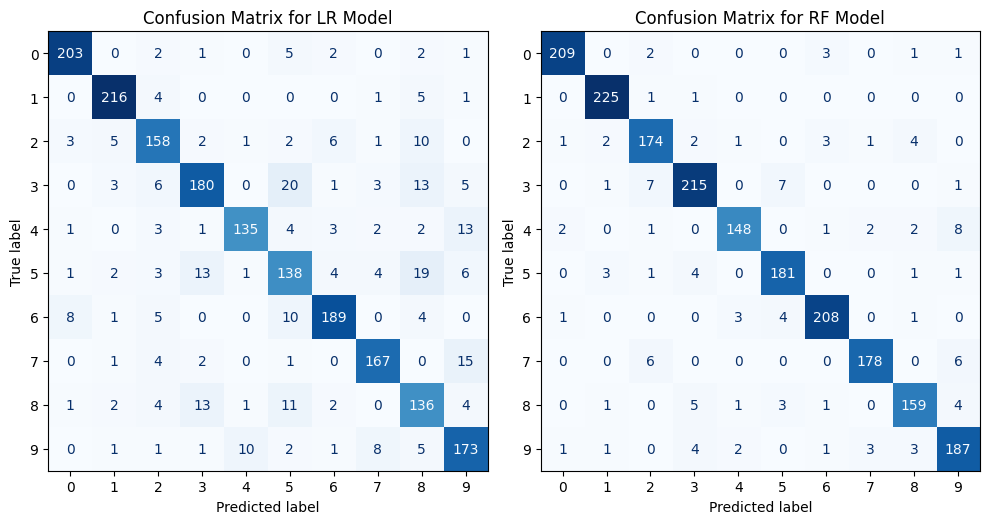

In [6]:
# --- Get predictions ---
y_pred_pixel_lr = model_pixel_lr.predict(X_test) 
y_pred_pixel_rf = pipe_pixel_rf.predict(X_test) 
# --- Create and plot the matrix ---
cm_pixel_lr = confusion_matrix(y_test, y_pred_pixel_lr)
cm_pixel_rf = confusion_matrix(y_test, y_pred_pixel_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pixel_lr, 
                              display_labels=['0','1','2','3','4','5','6','7','8','9'])
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pixel_rf, 
                              display_labels=['0','1','2','3','4','5','6','7','8','9'])

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(10, 10))
disp.plot(ax=ax[0], cmap='Blues',colorbar=False)
disp2.plot(ax = ax[1],cmap='Blues',colorbar=False)
ax[0].set_title("Confusion Matrix for LR Model")
ax[1].set_title("Confusion Matrix for RF Model")
plt.tight_layout()
plt.show()

The confusion matrices reveal that while both models perform well, they struggle with similar digit pairs.

Common Confusions: We see distinct clusters of errors between 4s and 9s, as well as 3s, 5s, and 8s. This makes intuitive sense in the 'Pixel View'—these digits share significant overlap in pixel intensity (e.g., the bottom loop of a 3 vs. a 5).

Model Differences: The Random Forest produces a cleaner diagonal with fewer off-diagonal errors, confirming that non-linear decision boundaries help capture the subtle pixel variations that distinguish these similar digits.

Let's look at some of these specific failures to understand why the pixel view falls short.

Let's inspect some of the specific images that confused the Logistic Regression model. Are these "hard" digits that even a human would struggle with, or are they obvious digits that the model simply missed?

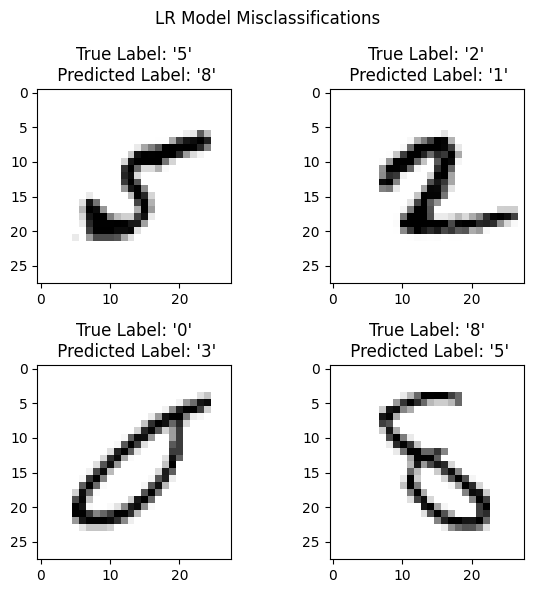

In [7]:
indexes = np.flatnonzero(y_pred_pixel_lr != y_test)
fig, axis = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
# 'axes.flat' gives you a 1D iterator: [ax(0,0), ax(0,1), ax(1,0), ax(1,1)]
# 'zip' pairs each axis with one of your indexes
for ax, index in zip(axis.flat, indexes[0:4]):
    img = X_test[index].reshape(28, 28)
    ax.imshow(img, cmap='gray_r')
    ax.set_title(f"True Label: '{y_test[index]}'\n Predicted Label: '{y_pred_pixel_lr[index]}'")
fig.suptitle("LR Model Misclassifications")
plt.tight_layout()
plt.show()

**Why does the model fail on clear images?** Because it is looking at pixel positions, not shapes. A slightly shifted or rotated '3' might have zero pixel overlap with a standard '3', causing the model to see it as a completely different object (like a '5'). This highlights the fundamental limitation of the "Pixel View": it is brittle to simple geometric variations.

Notice that the misclassified '8' (bottom right) is clearly an 8. However, because it is slightly thinner than average, its pixel values drifted into the "1" territory of the model's decision boundary.

## Chapter 2: The Global Geometry View (UMAP)
The significant performance gap between Random Forest (93.85%) and Logistic Regression (86.80%) confirms that the relationship between raw pixels and digit labels is highly non-linear. In the high-dimensional pixel space, the digits are likely twisted and curved in a way that a flat linear boundary cannot capture.

In this chapter, we will use UMAP (Uniform Manifold Approximation and Projection) to learn this global structure. Our goal is to "unfold" this manifold to see if capturing the global geometry simplifies the classification task.

In [8]:

#1. Build pipeline
umap_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),  #MinMaxScaler is best for this type of images
    #Apply UMAP
    ('umap', umap.UMAP(n_components=10, n_neighbors=15, random_state=13, target_weight=0.0),),  #target_weight=0.0 to make it fully unsupervised, i.e. it will ignore y_train
    #classifier
    ('classifier', LogisticRegression(random_state=13))
])


#2. Fit and calculate score
umap_pipe.fit(X_train,y_train)

umap_acc = umap_pipe.score(X_test,y_test)

print(f'UMAP Model accuracy:{umap_acc:.2%}')


UMAP Model accuracy:90.75%


The logistic regression model that achieved 86.80% accuracy on the 784 pixel features now achieved 90.90% accuracy when trained on only 10 features. This represents a 4.1% accuracy boost using only 1.28% of the number of features. This shows the power of the features produced by UMAP, fitting a simple linear model on it we get a result of comparable performance to a complex random forest model trained on 784 features.

To help us visualize what UMAP is doing, we can plot its first two features.

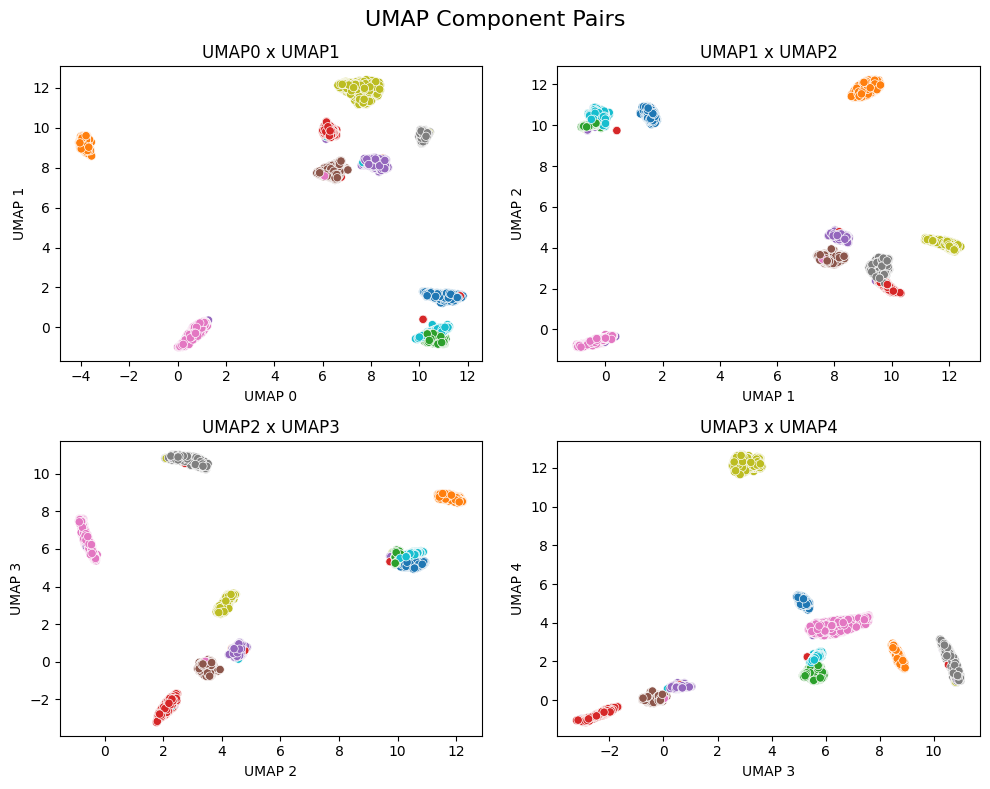

In [9]:
transformer_pipe = umap_pipe[:-1]

umap_features = transformer_pipe.transform(X_train)

fig,axis = plt.subplots(ncols=2,nrows=2, figsize = (10,8))
for ax, i in zip(axis.flat,range(4)):
    sns.scatterplot(ax = ax, x = umap_features[:,i], y = umap_features[:,i+1], hue = y_train, legend=False)
    ax.set_title(f'UMAP{i} x UMAP{i+1}')
    ax.set_xlabel(f'UMAP {i}')
    ax.set_ylabel(f'UMAP {i+1}')
fig.suptitle("UMAP Component Pairs", fontsize=16)
plt.tight_layout()
plt.show()

These graphs show us that UMAP identifies clusters that correspond roughly to the same digit. The clusters are almost totally separated, that is why we are able to obtain such a high accuracy feeding these features into a simple linear model.

We conclude that a huge ammount of the signal is encoded in the global, geometric shape of the dataset.

## Chapter 3: Local Topology

Previously, we saw that analyzing the global geometry of the entire dataset allowed us to produce highly relevant, low-dimensional features for classification.

The next step is to go one level deeper, from the dataset's global geometry to the local topology of each image. We will analyze the topological signature of each image individually by computing its persistent homology (using cubical persistence).

Imagine the digit is a landscape and we are flooding it with water. The 'topology' tracks how many islands (components) and lakes (loops) appear and disappear as the water level rises. An '8' will always have two loops, regardless of whether the line is jagged or smooth (noisy).

This will generate a new set of topological features (e.g., Betti curves) that describe a digit only by the birth and death of its components and loops.

Our goal is to answer the question: How much of a digit's identity is encoded in its pure topological shape? We will test this by training a classifier on only these topological features and comparing its performance to the full pixel-based model.

Before we apply this to the whole dataset, let us visualize how the persistence homology captures the difference between digits. 

Let us pick two digits:

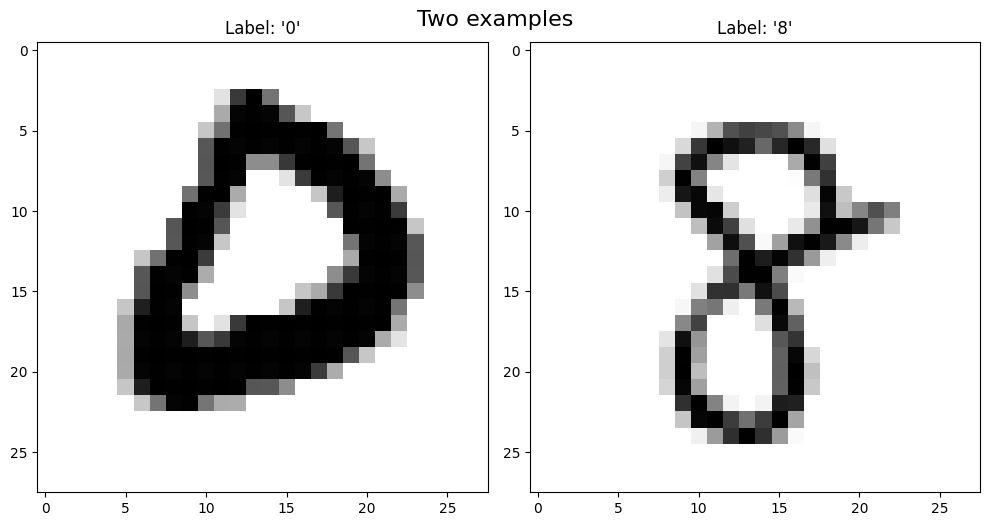

In [10]:
indexes = [5,13]
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(10,6))
# 'axes.flat' gives you a 1D iterator: [ax(0,0), ax(0,1), ax(1,0), ax(1,1)]
# 'zip' pairs each axis with one of your indexes
for ax, index in zip(axis.flat, indexes[:2]):
    img = X[index].reshape(28, 28)
    ax.imshow(img, cmap='gray_r')
    ax.set_title(f"Label: '{y[index]}'")
fig.suptitle("Two examples", y=0.9, fontsize = 16)
plt.tight_layout()
plt.show()

Now we will produce their corresponding persistence diagrams.

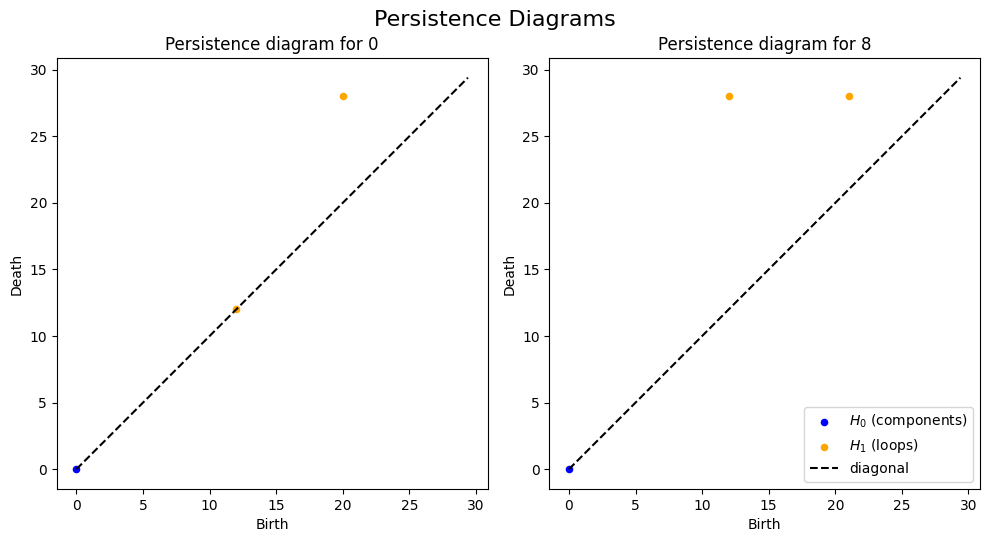

In [11]:
#images
imgs = X[indexes[0:2]]

#persistence pipeline
direction = [0,-1]
visual_pipe = Pipeline(steps=[
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', HeightFiltration(direction=np.array(direction))),
    ('cubical', CubicalPersistence(n_jobs=-1, homology_dimensions=(0,1)))
])

diagrams = visual_pipe.fit_transform(imgs.reshape((-1,28,28)))

#Plot diagrams
fig, axes = plt.subplots(figsize=(10,6),ncols=2)
for i in range(len(diagrams)):
    H0 = diagrams[i][diagrams[i][:,2] == 0]
    H1 = diagrams[i][diagrams[i][:,2] == 1]
    axes[i].scatter(H0[:, 0], H0[:, 1], c='blue', label='$H_0$ (components)', s=20)
    axes[i].scatter(H1[:, 0], H1[:, 1], c='orange', label='$H_1$ (loops)', s=20)
    #diagonal
    min_val = np.min(diagrams[i][:, :2])
    max_val = np.max(diagrams[i][:, :2])
    plot_lims = [min_val, max_val * 1.05] # Add a 5% buffer
    axes[i].plot(plot_lims, plot_lims, 'k--', label='diagonal')
    axes[i].set_xlabel('Birth')
    axes[i].set_ylabel('Death')
    axes[i].set_title(f'Persistence diagram for {y[indexes[i]]}')
    if i == 1:
        axes[i].legend(loc = 'lower right')
    axes[i].set_aspect('equal', 'box') # Make the plot square
fig.suptitle('Persistence Diagrams', fontsize = 16, y=0.91)
plt.tight_layout()
plt.show()

The persistent features are correspond to the points away from the diagonal. We can see that a 0 has one loop (corresponding to the one yellow point away from the diagonal) while an 8 has 2 loops. We visualize in the next graphs how the Betti Curves translate this information from the diagram into a vector to feed into a model.

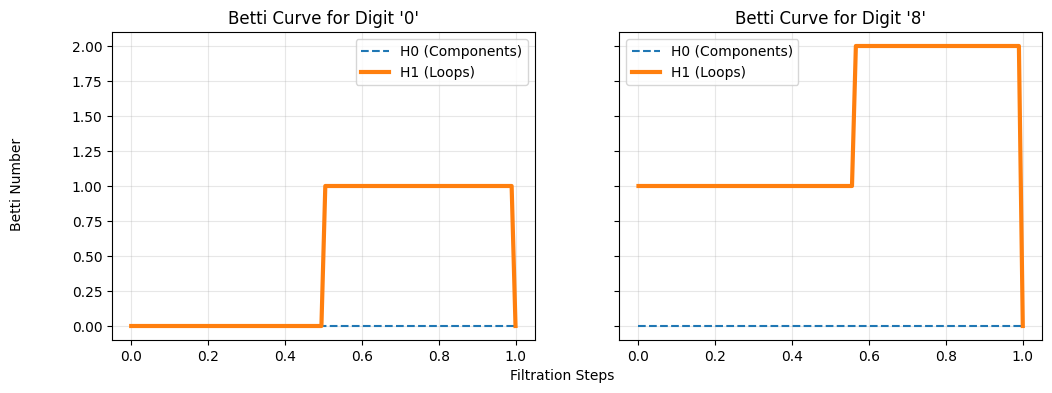

In [12]:
vectorization = BettiCurve(n_bins=100)
curves = vectorization.fit_transform(diagrams)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
x_axis = np.linspace(0, 1, 100) # The filtration axis (0 to 100%)

# Plot digit 0
axes[0].plot(x_axis, curves[0, 0, :], label='H0 (Components)', linestyle='--')
axes[0].plot(x_axis, curves[0, 1, :], label='H1 (Loops)', linewidth=3)
axes[0].set_title(f"Betti Curve for Digit '0'")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot digit 8
axes[1].plot(x_axis, curves[1, 0, :], label='H0 (Components)', linestyle='--')
axes[1].plot(x_axis, curves[1, 1, :], label='H1 (Loops)', linewidth=3)
axes[1].set_title(f"Betti Curve for Digit '8'")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.text(0.5, 0.01, 'Filtration Steps', ha='center')
fig.text(0.04, 0.5, 'Betti Number', va='center', rotation='vertical')

plt.show()

Before building the full pipeline, we verify that the topological features are stable across different samples of the same class. Below, we compute the persistence diagrams for two different instances of the digit '8'. We expect their topological signatures (loops and components) to be visually similar despite differences in handwriting style.

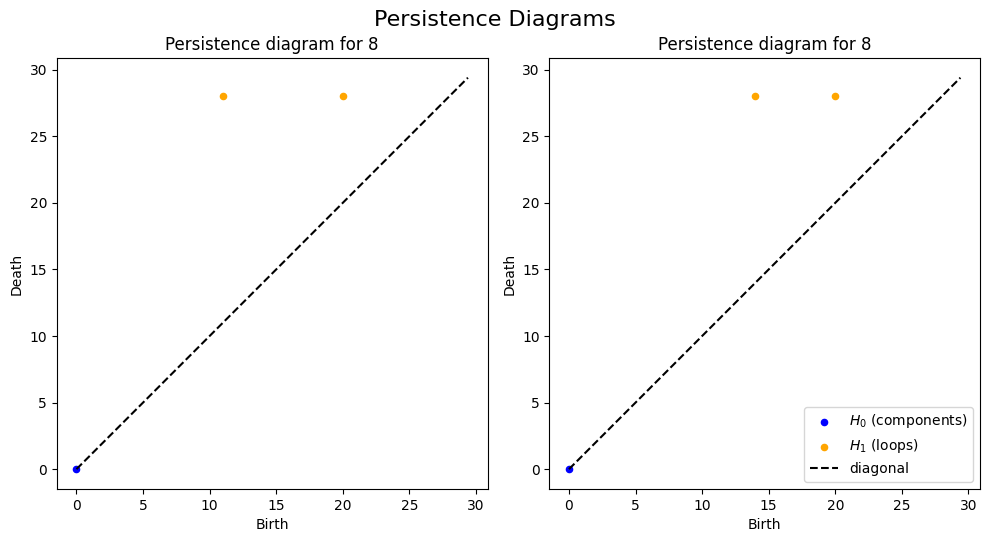

In [13]:
indexes = np.flatnonzero(y=='8')

#images
imgs = X[indexes[0:2]]

#persistence pipeline
direction = [0,-1]
visual_pipe = Pipeline(steps=[
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', HeightFiltration(direction=np.array(direction))),
    ('cubical', CubicalPersistence(n_jobs=-1, homology_dimensions=(0,1)))
])

diagrams = visual_pipe.fit_transform(imgs.reshape((-1,28,28)))

#Plot diagrams
fig, axes = plt.subplots(figsize=(10,6),ncols=2)
for i in range(len(diagrams)):
    H0 = diagrams[i][diagrams[i][:,2] == 0]
    H1 = diagrams[i][diagrams[i][:,2] == 1]
    axes[i].scatter(H0[:, 0], H0[:, 1], c='blue', label='$H_0$ (components)', s=20)
    axes[i].scatter(H1[:, 0], H1[:, 1], c='orange', label='$H_1$ (loops)', s=20)
    #diagonal
    min_val = np.min(diagrams[i][:, :2])
    max_val = np.max(diagrams[i][:, :2])
    plot_lims = [min_val, max_val * 1.05] # Add a 5% buffer
    axes[i].plot(plot_lims, plot_lims, 'k--', label='diagonal')
    axes[i].set_xlabel('Birth')
    axes[i].set_ylabel('Death')
    axes[i].set_title(f'Persistence diagram for {y[indexes[i]]}')
    if i == 1:
        axes[i].legend(loc = 'lower right')
    axes[i].set_aspect('equal', 'box') # Make the plot square
fig.suptitle('Persistence Diagrams', fontsize = 16, y=0.91)
plt.tight_layout()
plt.show()

As we expected, the diagrams are very similar.

We now construct the full end-to-end classification pipeline.

A single filtration direction can be ambiguous. 
* If we scan a **6** and a **9** from left-to-right, they might produce identical persistence diagrams (a single loop appearing at roughly the same step).
* To deal with this problem we will sweep across each image in **6 different directions**.
* When scanning from the top-down, the loop in the **9** appears *early*, while the loop in the **6** appears *late*. 

By concatenating features from multiple angles, we capture the relative spatial location of topological structures, significantly increasing the model's discriminative power.

In [14]:
# Reshape to (n_samples, n_pixels_x, n_pixels_y)
X_train_28 = X_train.reshape((-1,28,28))
X_test_28 = X_test.reshape((-1,28,28))




# --- 1. Creating pipeline ---
# we will binzarize the images before doing any computation, this will reduce noise
# we can eventually optimize the Binarizer threshold
# we choose to use Height Filtration and then CubicalPersistence on the images
# after scaling the diagrams we use Persitence entropy to obtain the topological quatities we run through a Random forest classifier


directions = [[1,0],[-1,0],[0,1],[0,-1],[1,1],[-1,-1]]
'''We sweep across the image in multiple directions 
to capture topological features that might be oriented differently.
For example, suppose we scan a 6 and a 9 from left to right. We will
find that they both have a loop at the same spot. If we scan the same
images from the top we will see that the 9 has a loop much earlier than the 6.
'''
transformers_list = [(
    f'filtration in direction {direction}',
    Pipeline(steps=[
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', HeightFiltration(direction=np.array(direction))),
    ('cubical', CubicalPersistence(n_jobs=-1, homology_dimensions=(0,1))),
    ('vectorization', BettiCurve(n_bins = 100, n_jobs=-1)),
    ('flattener', FunctionTransformer(lambda X: X.reshape(X.shape[0],-1))), #Betti Curve provides a 3-dim vector, we need to reshape it to feed into the RandomForest
    ]) 
)for direction in directions]

feature_union = FeatureUnion(transformer_list=transformers_list)

steps = [
    ('features', feature_union),
    ('classifier', RandomForestClassifier(random_state=13))
]

tda_pipe = Pipeline(
    steps=steps,
    )


# --- 2. Training the model ---

tda_pipe.fit(X_train_28,y_train)

tda_acc = tda_pipe.score(X_test_28,y_test)

print(f'TDA Model accuracy: {tda_acc:.2%}')



TDA Model accuracy: 93.35%


### Results: Topology vs. Pixels
The Topological model achieved **93.55% accuracy**, effectively matching the baseline Random Forest performance (**93.85%**) trained on raw pixels.

**Conclusion:**
This result confirms that a digit's identity is encoded in its **topological structure** (the birth/death of loops and components) rather than just its specific pixel values. By translating the image into Betti Curves via multi-directional filtration, we capture the fundamental shape signal without relying on exact pixel alignment.

## Chapter 4: The Importance of Filtration Time

**Motivation**
In Chapter 3, our Betti Curve model achieved high accuracy (~94%). Betti Curves preserve the *filtration index* (the "time" parameter), which tells the model **when** a feature appears (e.g., "a loop appeared early in the top-down scan").

To verify if this geometric context is necessary, we will retrain the model using **Persistence Entropy**.
* **What it is:** A summary statistic that measures the "complexity" of the topological features.
* **What it loses:** It sums up feature lifespans but discards their specific birth/death times.

If we remove the "when" information, the model will likely fail to distinguish digits that are topologically identical but geometrically distinct (e.g., **'0' vs. '9'**, which both have exactly one loop and one component). We expect a drop in accuracy and a specific confusion pattern between these pairs.

In [15]:
directions = [[1,0],[-1,0],[0,1],[0,-1],[1,1],[-1,-1]]

transformers_list = [(
    f'filtration in direction {direction}',
    Pipeline(steps=[
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', HeightFiltration(direction=np.array(direction))),
    ('cubical', CubicalPersistence(n_jobs=-1, homology_dimensions=(0,1))),
    ('vectorization', PersistenceEntropy(n_jobs=-1)),
    ('flattener', FunctionTransformer(lambda X: X.reshape(X.shape[0],-1))),
    ]) 
)for direction in directions]

feature_union = FeatureUnion(transformer_list=transformers_list)

steps = [
    ('features', feature_union),
    ('classifier', RandomForestClassifier(random_state=13))
]

tda_pipe_entropy = Pipeline(
    steps=steps,
    )


# --- 2. Training the model ---

tda_pipe_entropy.fit(X_train_28,y_train)
tda_entropy_acc = tda_pipe_entropy.score(X_test_28,y_test)

print(f'Entropy Model accuracy: {tda_entropy_acc:.2%}')



Entropy Model accuracy: 76.60%


As we expected, the accuracy is much lower for this model. Let us compare the confusion matrices.

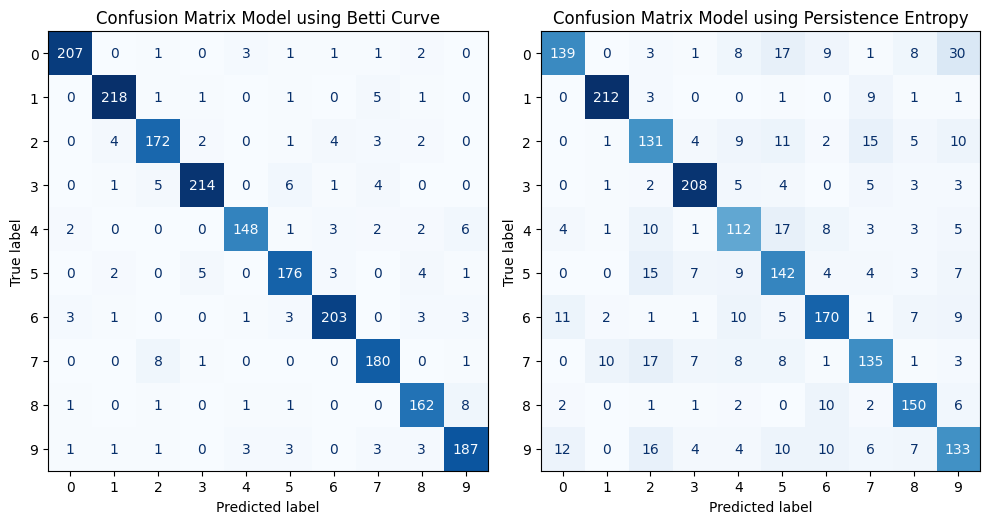

In [16]:
# --- Get your predictions ---
y_pred_betti = tda_pipe.predict(X_test_28) 
y_pred_entropy = tda_pipe_entropy.predict(X_test_28)
# --- Create and plot the matrix ---
cm_betti = confusion_matrix(y_test, y_pred_betti)
cm_entropy = confusion_matrix(y_test, y_pred_entropy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_betti, 
                              display_labels=['0','1','2','3','4','5','6','7','8','9'])
disp_entropy = ConfusionMatrixDisplay(confusion_matrix=cm_entropy, 
                              display_labels=['0','1','2','3','4','5','6','7','8','9'])

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(10, 10))
disp.plot(ax=ax[0], cmap='Blues',colorbar=False)
disp_entropy.plot(ax = ax[1],cmap='Blues',colorbar=False)
ax[0].set_title("Confusion Matrix Model using Betti Curve")
ax[1].set_title("Confusion Matrix Model using Persistence Entropy")
plt.tight_layout()
plt.show()

### Analysis of Confusion
The results confirm our hypothesis. The accuracy dropped significantly (**76.3%** vs **94.0%**), and the confusion matrix reveals exactly *why*:

  **Loss of Geometric Context:** * Pairs like **'6' vs '0'** and **'9' vs '0'** show high confusion. 
    * *Reason:* Topologically, a '0', '6', and '9' all consist of **one connected component** and **one loop**. Without the Betti Curve's filtration index (which tells us *when* the loop appears during the scan), these digits look topologically identical to the Entropy vectorizer.
    
  **Topological Noise:**
    * We observe increased confusion between **'2'** and **'9'**.
    * *Reason:* Handwritten '2's often contain a small "pseudo-loop" at the bottom left. To the Entropy metric, this small loop adds to the complexity score, making it indistinguishable from the genuine loop in a '9' without spatial context.

**Conclusion:**
 The BettiCurve vector preserves the filtration value (the 'when') of topological features, which is the key to distinguishing a '6' from a '9' or a '0' from a '6'. Persistence Entropy discards this and just measures 'topological complexity', which is not a strong enough signal. This proves that for TDA, how you vectorize the persistence diagram is a very critical step.

## Chapter 5: Model Robustness & Stress Testing

Real-world data is rarely clean. To evaluate the reliability of our topological features, we subject the models to two distinct types of stress:

1.  **Corruption (Salt & Pepper Noise):** Randomly toggling pixels to black or white.
    * *Hypothesis:* This destroys local topology (creating fake loops and holes). We expect the TDA model to degrade rapidly.
2.  **Deformation (Elastic Distortion):** Warping the image grid to simulate shaky handwriting or rotation.
    * *Hypothesis:* This preserves topology (an '8' is still an '8' even if squashed). We expect the TDA model to remain robust.

### Experiment A: Salt & Pepper Noise

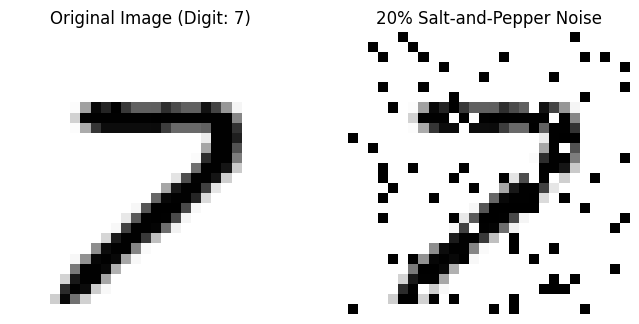

In [17]:
def inject_salt_and_pepper_noise(X, noise_level=0.2):
    """
    Applies salt-and-pepper noise to a batch of image data X.
    X is assumed to be an array of flattened images (n_samples, n_features).
    """
    X_noisy = X.copy()
    n_samples, n_features = X_noisy.shape
    
    # Calculate the total number of pixels to corrupt
    num_noise_pixels = int(n_features * noise_level)
    
    # Iterate over each sample
    for i in range(n_samples):
        # 1. Select random indices for 'salt' (max value)
        salt_indices = np.random.choice(n_features, size=num_noise_pixels // 2, replace=False)
        X_noisy[i, salt_indices] = 255.0  # Assuming 0-255 scale
        
        # 2. Select random indices for 'pepper' (min value)
        pepper_indices = np.random.choice(n_features, size=num_noise_pixels // 2, replace=False)
        X_noisy[i, pepper_indices] = 0.0
        
    return X_noisy

image_index = 13 # Pick an arbitrary sample

clean_image = X_test_28[image_index]

# Create the noisy dataset
X_test_noisy_pixels = inject_salt_and_pepper_noise(X_test)

# Reshape the corresponding noisy image for plotting
noisy_image = X_test_noisy_pixels[image_index].reshape(28, 28)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(clean_image, cmap='gray_r')
axes[0].set_title(f"Original Image (Digit: {y_test[image_index]})")
axes[0].axis('off')

axes[1].imshow(noisy_image, cmap='gray_r')
axes[1].set_title("20% Salt-and-Pepper Noise")
axes[1].axis('off')

plt.show()

Above we observe the effect of salt and pepper noise. Note how much it affects the topology of the figure, introducing several new loops and connected components. To a topological model the noisy '2' will look nothing like a '2', leading us to predict a massive drop in accuracy.

In [18]:
# --- 1. Evaluate Pixel-based Model  ---
accuracy_pixels_noisy = pipe_pixel_rf.score(X_test_noisy_pixels, y_test)

# --- 2. Evaluate UMAP-based Model  ---
accuracy_umap_noisy = umap_pipe.score(X_test_noisy_pixels, y_test)

# --- 3. Evaluate TDA-based Model ---
accuracy_tda_noisy = tda_pipe.score(X_test_noisy_pixels.reshape((-1,28,28)), y_test)

# Store results
robustness_results = pd.DataFrame({
    'Model': ['Raw Pixels (RF)', 'UMAP Features (LogReg)', 'TDA Features (RF)'],
    'Clean Accuracy': [pixel_rf_acc, umap_acc, tda_acc],
    'Noisy Accuracy': [accuracy_pixels_noisy, accuracy_umap_noisy, accuracy_tda_noisy],
    'Difference': np.array([pixel_rf_acc, umap_acc, tda_acc]) - np.array([accuracy_pixels_noisy, accuracy_umap_noisy, accuracy_tda_noisy])
})

print(robustness_results)

                    Model  Clean Accuracy  Noisy Accuracy  Difference
0         Raw Pixels (RF)          0.9420          0.9040      0.0380
1  UMAP Features (LogReg)          0.9075          0.9100     -0.0025
2       TDA Features (RF)          0.9335          0.1335      0.8000


### Experiment B: Elastic Deformation
As demonstrated above, random noise destroys the topological signal by creating "fake" loops. However, our primary interest is in **handwriting variation**, which is better modeled as geometric distortion rather than pixel corruption.

We now proceed to test the second part of our hypothesis: that TDA features will remain stable under **Elastic Deformation** (stretching and wiggling), even as the pixel-based baseline degrades.

In [19]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """
    Elastic deformation of images as described in [Simard2003]:
        Simard, Steinkraus and Platt, "Best Practices for
            Convolutional Neural Networks applied to Visual Document Analysis", in
            Proc. of the International Conference on Document Analysis and
            Recognition, 2003.
    alpha: Scaling factor (controls the intensity of the deformation).
    sigma: Smoothing factor (controls the smoothness of the deformation).
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    
    # 1. Generate random displacement fields (random noise)
    dx = random_state.rand(*shape) * 2 - 1
    dy = random_state.rand(*shape) * 2 - 1

    # 2. Smooth the noise to make it "elastic" (wobbly, not jagged)
    dx = gaussian_filter(dx, sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter(dy, sigma, mode="constant", cval=0) * alpha

    # 3. Calculate the new coordinates
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    # 4. Map the image to the new coordinates
    distorted_image = map_coordinates(image, indices, order=1, mode='reflect')
    
    return distorted_image.reshape(shape)

# --- Helper function to apply to the whole dataset ---
def create_elastic_dataset(X, alpha=10, sigma=3):
    X_deformed = X.copy()
    rows = X.shape[0]
    
    for i in range(rows):
        # Reshape flattened 784 -> 28x28
        img = X[i].reshape(28, 28)
        # Deform
        deformed = elastic_transform(img, alpha, sigma)
        # Flatten back
        X_deformed[i] = deformed.flatten()
        
    return X_deformed



### Visualizing the Deformation Regimes
Before analyzing the accuracy, it is crucial to understand what the **Smoothness (sigma)** parameter physically does to the image. We will fix the intensity parameter (alpha) at a high value (100) to ensure the deformations are significant.

As shown below:
1.  **Tearing Regime ($\sigma < 5$):** The deformation field is high-frequency. It acts like noise, tearing the digit.
2.  **Elastic Regime ($\sigma \approx 5-13$):** The field is smooth. The digit is warped and stretched (mimicking handwriting), but the topological loops remain intact.
3.  **Rigid Regime ($\sigma > 15$):** The field is too smooth to move pixels significantly. The image looks nearly identical to the original.

Let's visualize how these parameters distort a sample digit:

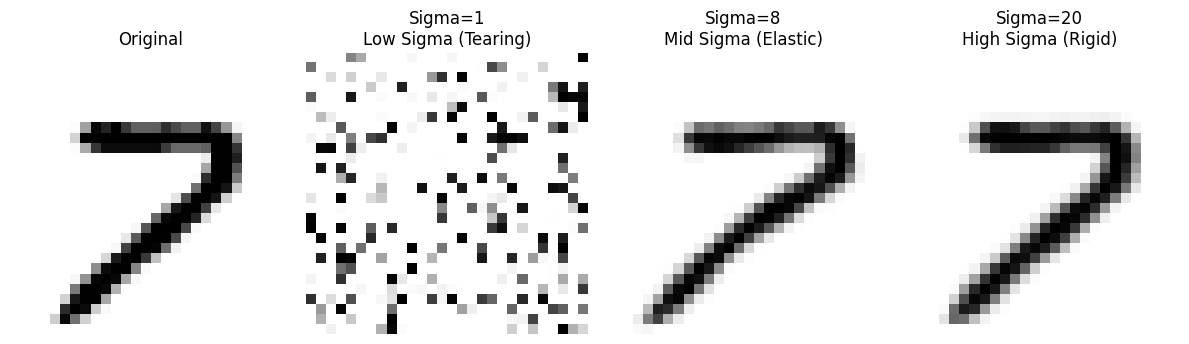

In [20]:
sample_idx = 13 
original_img = X_test[sample_idx].reshape(28, 28)

# Define the regimes
sigmas = [1, 8, 20] 
titles = ['Low Sigma (Tearing)', 'Mid Sigma (Elastic)', 'High Sigma (Rigid)']

plt.figure(figsize=(12, 4))

# Plot Original
plt.subplot(1, 4, 1)
plt.imshow(original_img, cmap='gray_r')
plt.title("Original")
plt.axis('off')

# Plot Deformations
for i, sigma in enumerate(sigmas):
    rs = np.random.RandomState(16)
    
    # Apply your elastic transform function
    deformed = elastic_transform(original_img, alpha=100, sigma=sigma, random_state=rs)
    
    plt.subplot(1, 4, i+2)
    plt.imshow(deformed, cmap='gray_r')
    plt.title(f"Sigma={sigma}\n{titles[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

With the visual regimes established, we now quantify the robustness of each model. We iterate through the smoothness parameter (sigma $\in [1, 20]$) while keeping the deformation intensity fixed at a high level (alpha=100).

**Hypothesis:**
We predict the **Topological Model** will significantly outperform the pixel baseline in the **Elastic Regime** (sigma $\approx 5-13$). In this window, the pixel-based classifier should fail due to spatial misalignment, whereas the TDA features (Betti Curves) should remain stable as the topological features are preserved.

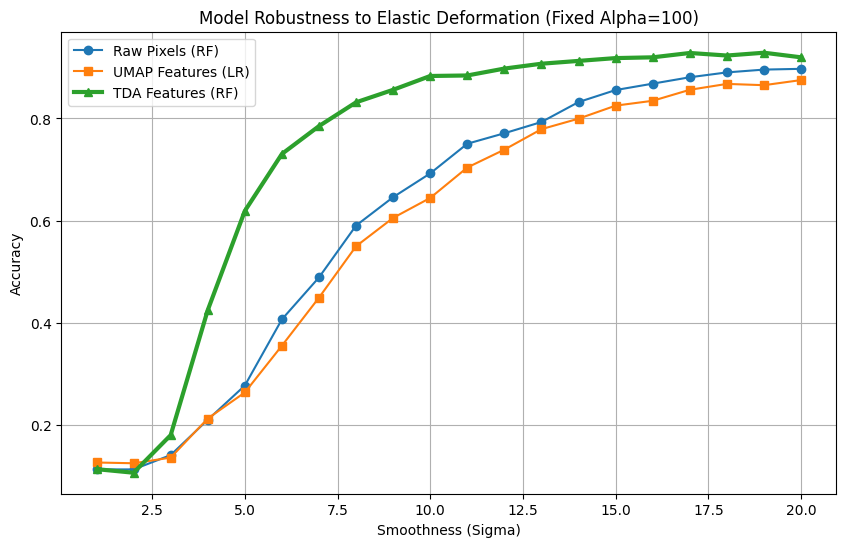

In [21]:
history = []

# Loop through smoothness (Sigma)
sigmas = range(1, 21) 


for sigma in sigmas:
    X_test_elastic = create_elastic_dataset(X_test, alpha=100, sigma=sigma)
    
    # 1. Pixel Model Score
    acc_pixels = pipe_pixel_rf.score(X_test_elastic, y_test)
    
    # 2. UMAP Score
    acc_umap = umap_pipe.score(X_test_elastic, y_test)
    
    # 3. TDA Score
    acc_tda = tda_pipe.score(X_test_elastic.reshape((-1, 28, 28)), y_test)
    
    history.append({
        'Sigma': sigma,
        'Pixels (RF)': acc_pixels,
        'UMAP (LogReg)': acc_umap,
        'TDA (RF)': acc_tda
    })

# Convert to DataFrame for easy plotting
df_results = pd.DataFrame(history)

# --- PLOT THE SENSITIVITY CURVE ---
plt.figure(figsize=(10, 6))
plt.plot(df_results['Sigma'], df_results['Pixels (RF)'], label='Raw Pixels (RF)', marker='o')
plt.plot(df_results['Sigma'], df_results['UMAP (LogReg)'], label='UMAP Features (LR)', marker='s')
plt.plot(df_results['Sigma'], df_results['TDA (RF)'], label='TDA Features (RF)', marker='^', linewidth=3)

plt.title('Model Robustness to Elastic Deformation (Fixed Alpha=100)')
plt.xlabel('Smoothness (Sigma)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Our experiments reveal two fundamental features of topological modeling:

1.  **Sensitivity to Corruption:** TDA is fragile to random noise (Salt & Pepper). A few rogue pixels can create spurious loops, destroying the topological signal.
2.  **Invariance to Deformation:** TDA is highly robust to geometric distortion (Elasticity). It correctly identifies shapes even when they are warped beyond the capabilities of pixel-based models.

**Chapter Takeaway:**
"Robustness" is not a binary property. 
* If the data suffers from **sensor noise** (static, dead pixels), a pixel-based or manifold learning approach is safer.
* If the data is clean but subject to **structural variance** (handwriting styles, biological cell deformation, soft-body robotics), the **Topological model** is the superior choice.

## Conclusion

In this project, we moved beyond standard pixel-based classification to explore the **geometric** and **topological** structure of the MNIST dataset.

### Key Findings
1.  **Geometry (UMAP):** The data lies on a low-dimensional manifold. By "unfolding" this global structure, we boosted the accuracy of a linear model from **86.8%** to **90.9%**, proving that geometric features carry significant signal.
2.  **Topology (TDA):** Local topological features (Betti Curves) alone achieved **~94% accuracy**, rivaling complex non-linear models (Random Forest) without ever seeing pixel coordinates.
3.  **The "When" Matters:** Our study with Persistence Entropy proved that knowing *that* a loop exists is insufficient; knowing *when* it appears (geometric context) is critical for telling apart digits like '6' vs '9'.
4.  **Robustness Trade-off:**
    * **Weakness:** TDA is highly sensitive to pixel corruption (Salt & Pepper noise), where accuracy crashed by 80%.
    * **Strength:** TDA is exceptionally robust to **Elastic Deformation**. In the regime mimicking natural handwriting variation, topological features outperformed the pixel baseline.

This analysis suggests two uses for Topological Data Analysis:
*  **A Robust Classifier:** For domains with high shape variance but reliable sensors (e.g., handwriting recognition, classifying biological cells that deform), TDA offers superior performance to pixel-based baselines.
*  **An Integrity Monitor:** Because TDA is hypersensitive to pixel corruption (Salt & Pepper noise), it serves as an excellent structural integrity check (e.g. In an automated check-processing pipeline, if the Pixel Model predicts a digit with high confidence but the Topological Model fails, the system can flag the image as corrupted, diverting it for human review.)